In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
#Carregar os dados processados
path = '../data/processed/churn_train_ready.csv'

df = pd.read_csv(path)

In [3]:
#Separar Variaveis e alvo (X e y)
X = df.drop('Churn', axis = 1 )
y= df['Churn']

In [4]:
#Divisão Treino vs Test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Treinando com {X_train.shape[0]} clientes e testando com {X_test.shape[0]}.")

Treinando com 5634 clientes e testando com 1409.


In [5]:
# 1. Diagnóstico: Quantos vazios temos?
print(f"Tamanho antes: {y_train.shape}")
qtd_nans = y_train.isna().sum()
print(f"Quantidade de NaNs no y_train: {qtd_nans}")

Tamanho antes: (5634,)
Quantidade de NaNs no y_train: 0


In [6]:
#treinar o modelo
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [7]:
#fazer predição
y_pred = modelo.predict(X_test)

In [8]:
#Avaliar o Resultado Inicial
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred))


Relatório de Classificação:

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1036
           1       0.66      0.45      0.53       373

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409



### A Leitura do Diagnóstico

1. Onde o modelo é ÓTIMO (Classe 0 - Quem Fica)

    Recall 0.92: De todos os clientes que realmente ficaram, o modelo acertou 92%. Ele entende muito bem o perfil do cliente fiel.

2. Onde o modelo está SOFRENDO (Classe 1 - Quem Sai) Este é o ponto crítico. A classe 1 é o Churn, e é ela que queremos prever para evitar perder dinheiro.

    Precision 0.66: Quando o modelo diz "Esse cliente vai sair", ele acerta 66% das vezes. É um número aceitável (não vamos gastar muito cupom de desconto à toa).

    Recall 0.45 (O Problema): De todos os clientes que realmente saíram, o modelo só detectou 45%.

        Tradução: Se 100 clientes cancelarem amanhã, seu modelo só vai te avisar de 45 deles. Os outros 55 vão sair "de surpresa" sem você agir.

### Isso acontece pois o dataset é desbalanceado

In [9]:
# Adicione class_weight='balanced'
modelo = RandomForestClassifier(n_estimators=100, 
                                class_weight='balanced',  # <--- O segredo aqui
                                random_state=42)

modelo.fit(X_train, y_train)

# Verifique o novo relatório
from sklearn.metrics import classification_report
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1036
           1       0.67      0.45      0.54       373

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409



#### usando class_weight não fez diferença 

#### tentar ajustar o threshold

In [10]:
from sklearn.metrics import classification_report

# 1. Pegar as probabilidades em vez da classificação final
# (Isso retorna duas colunas: chance de ser 0 e chance de ser 1)
probs = modelo.predict_proba(X_test)

# Pegamos apenas a coluna 1 (chance de Churn)
probs_churn = probs[:, 1]

# 2. Definir um novo limite de corte (Threshold)
# Vamos testar 0.40 (40%) em vez do padrão 0.50
novo_threshold = 0.40

# Criar a nova previsão baseada nesse corte
y_pred_ajustado = (probs_churn >= novo_threshold).astype(int)

# 3. Ver o resultado
print(f"--- RELATÓRIO COM THRESHOLD {novo_threshold} ---")
print(classification_report(y_test, y_pred_ajustado))

--- RELATÓRIO COM THRESHOLD 0.4 ---
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1036
           1       0.60      0.62      0.61       373

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409



### Mas o que faz o cliente cancelar?

/tmp/ipykernel_29893/727300909.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_importancias.head(10), palette='viridis')


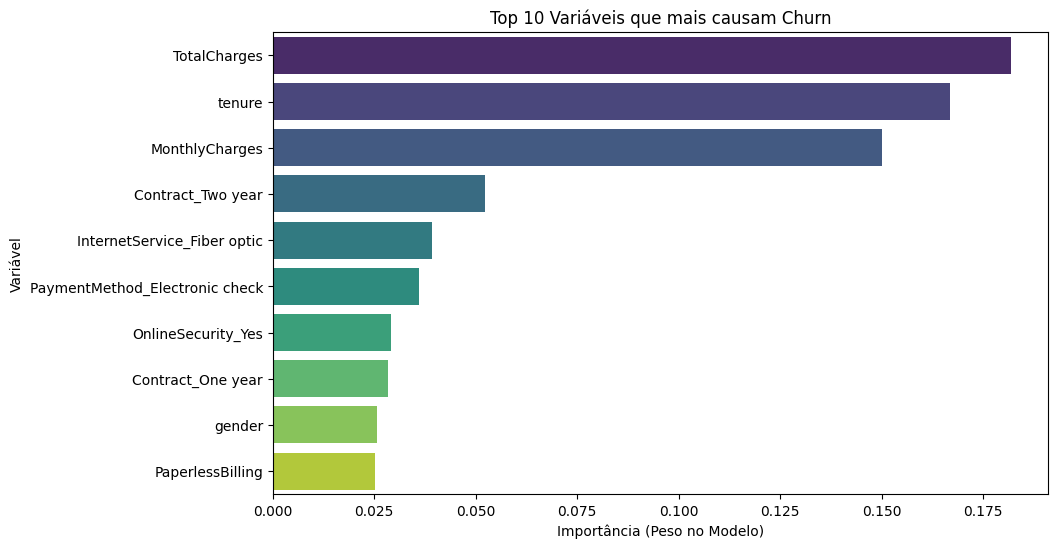

                           Feature  Importance
8                     TotalCharges    0.181781
4                           tenure    0.166788
7                   MonthlyCharges    0.149920
26               Contract_Two year    0.052320
11     InternetService_Fiber optic    0.039269
28  PaymentMethod_Electronic check    0.035922
14              OnlineSecurity_Yes    0.029016
25               Contract_One year    0.028306
0                           gender    0.025759
6                 PaperlessBilling    0.025294


In [11]:
# 1. Pegar a importância de cada variável
importancias = modelo.feature_importances_

# 2. Criar um DataFrame para organizar
df_importancias = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importancias
})

# 3. Ordenar do maior para o menor
df_importancias = df_importancias.sort_values(by='Importance', ascending=False)

# 4. Plotar o Top 10
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=df_importancias.head(10), palette='viridis')
plt.title('Top 10 Variáveis que mais causam Churn')
plt.xlabel('Importância (Peso no Modelo)')
plt.ylabel('Variável')
plt.show()

# Mostrar a tabela textual também
print(df_importancias.head(10))

#### Tenure (Tempo de Casa): 

    Interpretação: Clientes novos são instáveis. Se o cliente sobrevive aos primeiros meses, a chance de ele cancelar cai drasticamente. Fidelidade blinda o cliente.

#### MonthlyCharges (Mensalidade): O bolso dói.

    Interpretação: Clientes com contas mais altas são mais exigentes. Se o serviço falhar ou se o concorrente oferecer algo mais barato, eles saem. Clientes que pagam pouco (planos básicos) tendem a "esquecer" a conta e ficam.

#### TotalCharges:

    Essa é curiosa, pois é uma combinação das duas anteriores (Tempo x Mensalidade). Ela indica o Lifetime Value (LTV).

## O gráfico de importância diz QUEM manda, mas não diz COMO.

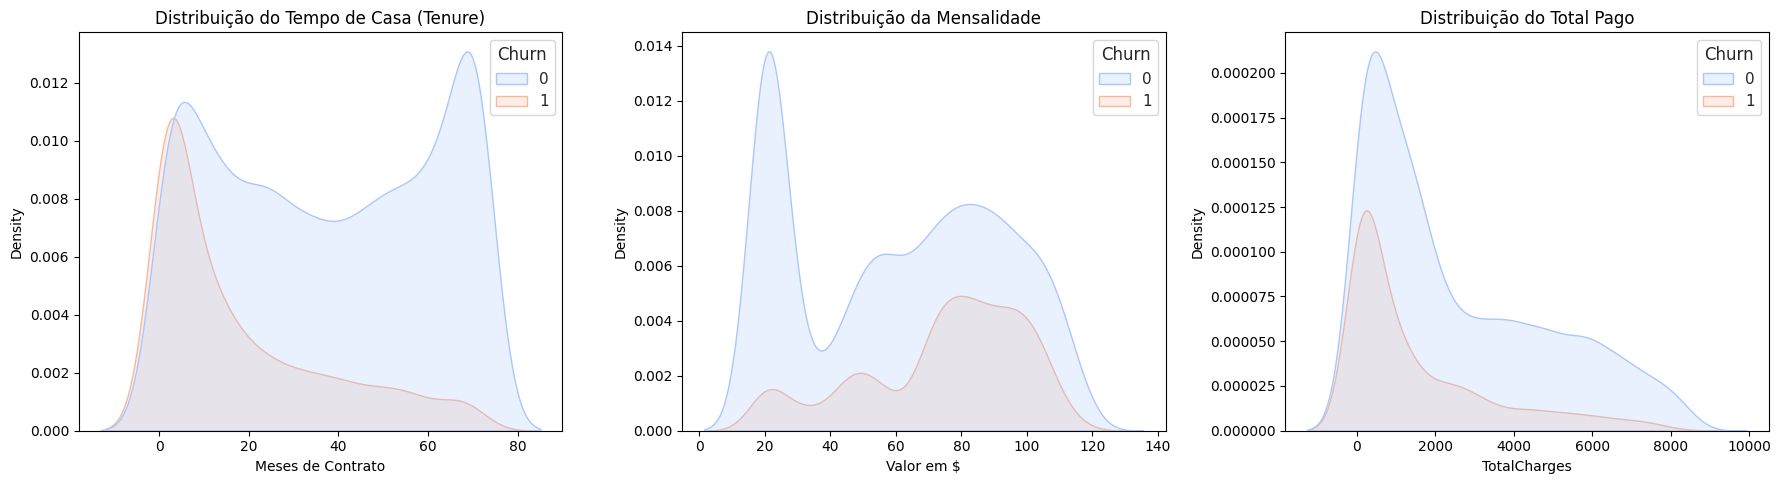

In [12]:
# Configuração visual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.set(style="whitegrid")

# 1. Gráfico de Tenure (Tempo de casa)
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, palette='coolwarm', ax=axes[0])
axes[0].set_title('Distribuição do Tempo de Casa (Tenure)')
axes[0].set_xlabel('Meses de Contrato')

# 2. Gráfico de MonthlyCharges (Mensalidade)
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, palette='coolwarm', ax=axes[1])
axes[1].set_title('Distribuição da Mensalidade')
axes[1].set_xlabel('Valor em $')

# 3. Gráfico de TotalCharges
# (Como TotalCharges pode ter vindo como texto ou ter nulos, garantimos que é numérico)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce') 
sns.kdeplot(data=df, x='TotalCharges', hue='Churn', fill=True, palette='coolwarm', ax=axes[2])
axes[2].set_title('Distribuição do Total Pago')

plt.tight_layout()
plt.show()

### Alguns Insghts 

#### Do grafico mais a esquerda (Tenure):
##### O risco de cancelamento é crítico no primeiro ano. Se o cliente passa dos 12 meses, ele fideliza.

##### A empresa precisa focar 80% do esforço de retenção no Onboarding (boas-vindas). Se o cliente sobreviver aos primeiros 3 meses, a chance de ele ficar é alta.

#### Do grafico do meio (Valor da mensalidade):
##### Clientes de alto valor (High Ticket) são os mais insatisfeitos ou os mais assediados pela concorrência.
##### Não adianta dar desconto para quem paga $20. O foco da retenção tem que ser nos clientes Premium. Talvez o serviço caro não esteja entregando valor suficiente.



In [13]:
if not os.path.exists('../models'):
    os.makedirs('../models')

# 1. Salvar o Modelo Treinado
joblib.dump(modelo, '../models/random_forest_v1.pkl')

# 2. IMPORTANTE: Salvar também a lista de colunas usadas no treino
# (Para garantir que novos dados entrem na mesma ordem)
colunas_treino = X_train.columns.tolist()
joblib.dump(colunas_treino, '../models/features_names.pkl')

print("✅ Modelo e lista de features salvos com sucesso na pasta 'models'!")
print("Seu projeto de Machine Learning está concluído! 🚀")

✅ Modelo e lista de features salvos com sucesso na pasta 'models'!
Seu projeto de Machine Learning está concluído! 🚀
